- Edições Julio Patti em **<span style="color:red;">VERMELHO</span>**
- Traduzido pelo **Copilot**
# Industrial Safety and Health Analytics Database

## Conteúdo
O banco de dados basicamente contém registros de acidentes de 12 plantas diferentes em 03 países diferentes, onde cada linha nos dados é uma ocorrência de um acidente.

## Descrição das Colunas
- **Data**: informação de data/hora ou data específica
- **Countries**: em qual país o acidente ocorreu (anonimizado)
- **Local**: a cidade onde a planta de fabricação está localizada (anonimizado)
- **Industry sector**: a qual setor a planta pertence
- **Accident level**: de I a VI, registra quão grave foi o acidente (I significa não severo, enquanto VI significa muito severo)**<span style="color:red;"> (Só encontrado de I a V)</span>**
- **Potential Accident Level**: Dependendo do Nível de Acidente, o banco de dados também registra quão grave o acidente poderia ter sido (devido a outros fatores envolvidos no acidente)**<span style="color:red;"> (Só encontrado 1 caso VI que foi considerado V posteriormente)</span>**
- ~~**Genre**: se a pessoa é do sexo masculino ou feminino~~ **<span style="color:red;">Excluída</span>**
- ~~**Employee or Third Party**: se a pessoa ferida é um funcionário ou um terceiro~~ **<span style="color:red;">Excluída</span>**
- **Critical Risk**: alguma descrição do risco envolvido no acidente
- **Description**: Descrição detalhada de como o acidente aconteceu.

FONTE: [kaggle](https://www.kaggle.com/datasets/ihmstefanini/industrial-safety-and-health-analytics-database?resource=download)

In [1]:
import pandas as pd
import glob
from roman import fromRoman
import numpy as np
import sqlite3

files = glob.glob('data/IHMStefanini_industrial_safety_and_health_database_*.csv')
df = pd.read_csv(files[0]).drop(columns=['Unnamed: 0', 
                                         'Genre', 
                                         'Employee or Third Party']).drop_duplicates().reset_index(drop=True)
print(f'Shape: {df.shape}')
df.head()

Shape: (415, 8)


,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Manual Tools,In the sub-station MILPO located at level +170...
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Others,Approximately at 11:45 a.m. in circumstances t...


# Distribuições

In [2]:
for col in df.columns:
    if col not in ['Data', 'Description']:
        vc = df[col].value_counts(dropna=False)
        if len(vc) > 10:
            vc = f'{col}\n\n'+ str([(index, int(count)) for index, count in zip(vc.index, vc.values)])
        print(f"\n{'-'*120}\n{vc}")


------------------------------------------------------------------------------------------------------------------------
Countries
Country_01    246
Country_02    128
Country_03     41
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------
Local

[('Local_03', 88), ('Local_05', 59), ('Local_01', 55), ('Local_04', 55), ('Local_06', 46), ('Local_10', 41), ('Local_08', 27), ('Local_02', 23), ('Local_07', 13), ('Local_12', 4), ('Local_09', 2), ('Local_11', 2)]

------------------------------------------------------------------------------------------------------------------------
Industry Sector
Mining    234
Metals    134
Others     47
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------
Accident Level
I      306
II      40
III     31
IV      30
V        8
Name: count, dtype: int64

--------------------

# Investigação de conflitos
- Descrições duplicadas com outros campos distintos
    - Alguns casos não poderiam ter, por exemplo, uma mesma descrição e Nivel de acidente diferente.
    - Casos em que existe risco critico diferentes Other vs Não Other será mantido o Não Other

In [3]:
cond_dup = df['Description'].duplicated(keep=False)
print(f'{cond_dup.sum()} casos envolvidos:')
df[cond_dup].sort_values(['Description'])

8 casos envolvidos:


,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Critical Risk,Description
164,2016-07-07 00:00:00,Country_01,Local_03,Mining,IV,V,Others,At moments when the MAPERU truck of plate F1T ...
165,2016-07-07 00:00:00,Country_01,Local_03,Mining,I,IV,Others,At moments when the MAPERU truck of plate F1T ...
128,2016-05-26 00:00:00,Country_03,Local_10,Others,I,I,Bees,"In the geological reconnaissance activity, in ..."
129,2016-05-26 00:00:00,Country_03,Local_10,Others,I,I,Others,"In the geological reconnaissance activity, in ..."
141,2016-06-08 00:00:00,Country_03,Local_10,Others,I,I,Bees,Project of Vazante that carried out sediment c...
142,2016-06-08 00:00:00,Country_03,Local_10,Others,I,I,Others,Project of Vazante that carried out sediment c...
379,2017-05-06 00:00:00,Country_02,Local_07,Mining,IV,V,Projection,The employees Márcio and Sérgio performed the ...
380,2017-05-06 00:00:00,Country_02,Local_07,Mining,II,V,Projection,The employees Márcio and Sérgio performed the ...


# Tratamento Particular
- Drop conflitos e priorização de Riscos diferentes de Others
- Somente 1 acidente potencial nivel VI -> Será considerado nível V

In [4]:
drop_desc = []
for desc in df[cond_dup]['Description'].unique().tolist():
    cond_desc = df['Description']==desc
    df_desc = df[cond_desc]
    if len(df_desc['Accident Level'].unique())>1:
        drop_desc.append(desc)
    riscos = df_desc['Critical Risk'].unique().tolist()
    if len(riscos)==2:
        if 'Others' in df_desc['Critical Risk'].unique():
            riscos.remove('Others')
            cond_other = df_desc['Critical Risk']=='Others'
            df.loc[cond_other & cond_desc, 'Critical Risk'] = riscos[0]

cond_drop_conflict = df['Description'].isin(drop_desc)
df = df[~cond_drop_conflict].drop_duplicates().reset_index(drop=True)
df.shape       

(409, 8)

In [5]:
cond_level_6 = df['Potential Accident Level']=='VI'
df.loc[cond_level_6, 'Potential Accident Level'] = 'V'
df['Potential Accident Level'].value_counts()

Potential Accident Level
IV     138
III    106
II      95
I       43
V       27
Name: count, dtype: int64

In [6]:
int(df['Description'].duplicated().sum())

0

# Tratamento geral
- Mudança de nomes de colunas
- Passagem de valores de strings para lowercase (exeto a descrição do evento)

In [7]:
df.rename(columns={'Data':'DATE', 
                   'Countries':'COUNTRY', 
                   'Local': 'PLACE', 
                   'Industry Sector':'SECTOR',
                   'Accident Level': 'ACCIDENT_LEVEL',
                   'Potential Accident Level': 'DANGEROUSNESS',
                   'Critical Risk': 'CRITICAL_RISK',
                   'Description': 'DESCRIPTION'
                  }, inplace=True)

df['DATE'] = pd.to_datetime(df['DATE'])
df['ACCIDENT_LEVEL'] = df['ACCIDENT_LEVEL'].apply(fromRoman)
df['DANGEROUSNESS'] = df['DANGEROUSNESS'].apply(fromRoman)
for col in ['COUNTRY', 'PLACE', 'SECTOR', 'CRITICAL_RISK']:
    df[col] = df[col].str.lower()

df

,DATE,COUNTRY,PLACE,SECTOR,ACCIDENT_LEVEL,DANGEROUSNESS,CRITICAL_RISK,DESCRIPTION
0,2016-01-01,country_01,local_01,mining,1,4,pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02,country_02,local_02,mining,1,4,pressurized systems,During the activation of a sodium sulphide pum...
2,2016-01-06,country_01,local_03,mining,1,3,manual tools,In the sub-station MILPO located at level +170...
3,2016-01-08,country_01,local_04,mining,1,1,others,Being 9:45 am. approximately in the Nv. 1880 C...
4,2016-01-10,country_01,local_04,mining,4,4,others,Approximately at 11:45 a.m. in circumstances t...
...,...,...,...,...,...,...,...,...
404,2017-07-04,country_01,local_04,mining,1,3,others,"Being approximately 5:00 a.m. approximately, w..."
405,2017-07-04,country_01,local_03,mining,1,2,others,The collaborator moved from the infrastructure...
406,2017-07-05,country_02,local_09,metals,1,2,venomous animals,During the environmental monitoring activity i...
407,2017-07-06,country_02,local_05,metals,1,2,cut,The Employee performed the activity of strippi...


# Industrial Safety and Health Analytics Database

## Adaptado

## Descrição das Colunas
- **DATE**: informação de data/hora ou data específica
- **COUNTRY**: em qual país o acidente ocorreu (anonimizado)
- **PLACE**: a cidade onde a planta de fabricação está localizada (anonimizado)
- **SECTOR**: a qual setor a planta pertence
- **ACCIDENT_LEVEL**: de 1 a 5, registra quão grave foi o acidente (1 significa não severo, enquanto 5 significa muito severo)
- **DANGEROUSNESS**: Dependendo do Nível de Acidente, o banco de dados também registra quão grave o acidente poderia ter sido (devido a outros fatores envolvidos no acidente)
- **CRITICAL_RISK**: alguma descrição do risco envolvido no acidente/keyword
- **DESCRIPTION**: Descrição detalhada de como o acidente aconteceu.

FONTE: [kaggle](https://www.kaggle.com/datasets/ihmstefanini/industrial-safety-and-health-analytics-database?resource=download)


# SQLite
- criando uma coluna de ID

In [8]:
columns = df.columns.tolist()
df.reset_index(inplace=True)
df.columns = ['ID'] + columns
df['ID'] += 1

df.head(1)

,ID,DATE,COUNTRY,PLACE,SECTOR,ACCIDENT_LEVEL,DANGEROUSNESS,CRITICAL_RISK,DESCRIPTION
0,1,2016-01-01,country_01,local_01,mining,1,4,pressed,While removing the drill rod of the Jumbo 08 f...


In [9]:
# Conexão com o banco de dados
conn = sqlite3.connect('database.db')

# Criação de Tabela
conn.execute("""
CREATE TABLE IF NOT EXISTS events (
    ID INTEGER PRIMARY KEY,
    DATE DATETIME,
    COUNTRY TEXT,
    PLACE TEXT,
    SECTOR TEXT,
    ACCIDENT_LEVEL INTEGER,
    DANGEROUSNESS INTEGER,
    CRITICAL_RISK TEXT,
    DESCRIPTION TEXT
);
""")

# Inserção de dados na tabela
df.to_sql('events', conn, if_exists='replace', index=False)

409

In [10]:
# Teste de leitura
query = "SELECT * FROM events"
engine = sqlite3.Connection('database.db')

df = pd.read_sql(query, 
                 engine, 
                 dtype={ 'ID': 'int64', 
                        'COUNTRY': 'str', 
                        'PLACE': 'str', 
                        'SECTOR': 'str', 
                        'ACCIDENT_LEVEL': 'int64',
                        'DANGEROUSNESS': 'int64', 
                        'CRITICAL_RISK': 'str', 
                        'DESCRIPTION': 'str' },
                 parse_dates=['DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              409 non-null    int64         
 1   DATE            409 non-null    datetime64[ns]
 2   COUNTRY         409 non-null    object        
 3   PLACE           409 non-null    object        
 4   SECTOR          409 non-null    object        
 5   ACCIDENT_LEVEL  409 non-null    int64         
 6   DANGEROUSNESS   409 non-null    int64         
 7   CRITICAL_RISK   409 non-null    object        
 8   DESCRIPTION     409 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 28.9+ KB


In [11]:
df.describe(include='all')

,ID,DATE,COUNTRY,PLACE,SECTOR,ACCIDENT_LEVEL,DANGEROUSNESS,CRITICAL_RISK,DESCRIPTION
count,409.000000,409,409,409,409,409.000000,409.000000,409,409
unique,NaN,NaN,3,12,3,NaN,NaN,33,409
top,NaN,NaN,country_01,local_03,mining,NaN,NaN,others,While removing the drill rod of the Jumbo 08 f...
freq,NaN,NaN,244,86,230,NaN,NaN,222,1
mean,205.000000,2016-09-18 07:16:34.621026816,NaN,NaN,NaN,1.530562,3.026895,NaN,NaN
min,1.000000,2016-01-01 00:00:00,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN
25%,103.000000,2016-04-30 00:00:00,NaN,NaN,NaN,1.000000,2.000000,NaN,NaN
50%,205.000000,2016-09-06 00:00:00,NaN,NaN,NaN,1.000000,3.000000,NaN,NaN
75%,307.000000,2017-02-05 00:00:00,NaN,NaN,NaN,2.000000,4.000000,NaN,NaN
max,409.000000,2017-07-09 00:00:00,NaN,NaN,NaN,5.000000,5.000000,NaN,NaN


In [12]:
for col in df.columns:
    if col not in ['DATE', 'DESCRIPTION', 'ID']:
        vc = df[col].value_counts(dropna=False)
        if len(vc) > 10:
            vc = f'{col}\n\n'+ str([(index, int(count)) for index, count in zip(vc.index, vc.values)])
        print(f"\n{'-'*120}\n{vc}")


------------------------------------------------------------------------------------------------------------------------
COUNTRY
country_01    244
country_02    126
country_03     39
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------
PLACE

[('local_03', 86), ('local_05', 59), ('local_01', 55), ('local_04', 55), ('local_06', 46), ('local_10', 39), ('local_08', 27), ('local_02', 23), ('local_07', 11), ('local_12', 4), ('local_09', 2), ('local_11', 2)]

------------------------------------------------------------------------------------------------------------------------
SECTOR
mining    230
metals    134
others     45
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------
ACCIDENT_LEVEL
1    303
2     39
3     31
4     28
5      8
Name: count, dtype: int64

-----------------------------------------

# Testes Ferramenta
- Guardrails se mostraram uteis para encontrar erros
- Desenpenho SQL aumenta com o incremento de shots
- Precisa de mais ajustes, shots, melhorias em prompts.
- Melhorar plots

In [19]:
from src.assistant import SQLite_Analyser
import matplotlib.pyplot as plt

analisador = SQLite_Analyser("qwen3:30b-a3b", 'database.db')





query prompt: 

SQL query: SELECT ACCIDENT_LEVEL, COUNT(*) AS total_events FROM events GROUP BY ACCIDENT_LEVEL;
   ACCIDENT_LEVEL  total_events
0               1           303
1               2            39
2               3            31
3               4            28
4               5             8


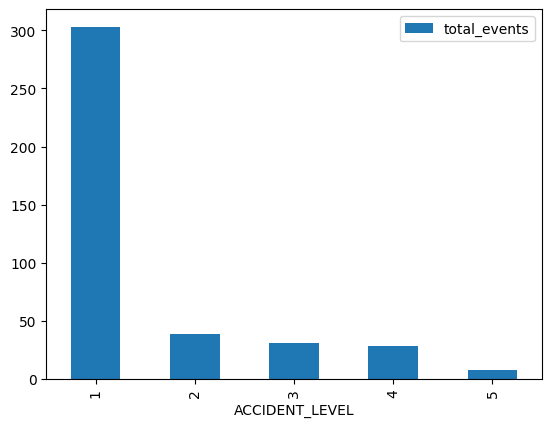

In [20]:
question = 'Quantos eventos existem em cada level de acidente?'
analisador.apresentar(question)





query prompt: 

SQL query: SELECT ACCIDENT_LEVEL, COUNT(*) AS total_events FROM events GROUP BY ACCIDENT_LEVEL;
   ACCIDENT_LEVEL  total_events
0               1           303
1               2            39
2               3            31
3               4            28
4               5             8


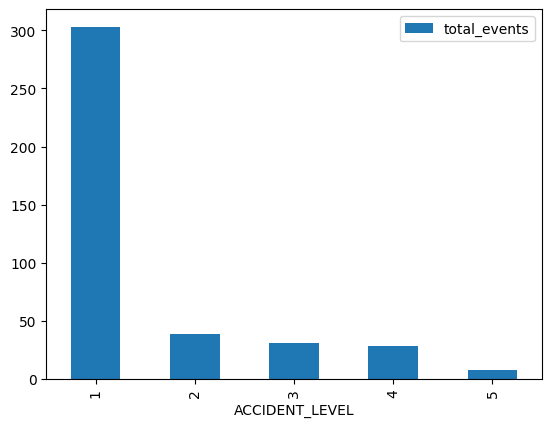

In [21]:
question = 'Quantos eventos existem em cada level de acidente?'
analisador.apresentar(question)

# Exemplo texto

In [22]:
question = 'Quantos eventos existem ao todo?'
analisador.apresentar(question)





query prompt: 

SQL query: SELECT COUNT(*) AS total_events FROM events;


'A quantidade total de eventos é 409.'

# Exemplo Linha





query prompt: 

SQL query: SELECT strftime('%Y-%m', DATE) AS month, COUNT(*) AS total_events FROM events GROUP BY strftime('%Y-%m', DATE);
      month  total_events
0   2016-01            12
1   2016-02            30
2   2016-03            34
3   2016-04            28
4   2016-05            25
5   2016-06            30
6   2016-07            17
7   2016-08            21
8   2016-09            24
9   2016-10            21
10  2016-11            13
11  2016-12            22
12  2017-01            27
13  2017-02            30
14  2017-03            16
15  2017-04            23
16  2017-05            12
17  2017-06            19
18  2017-07             5


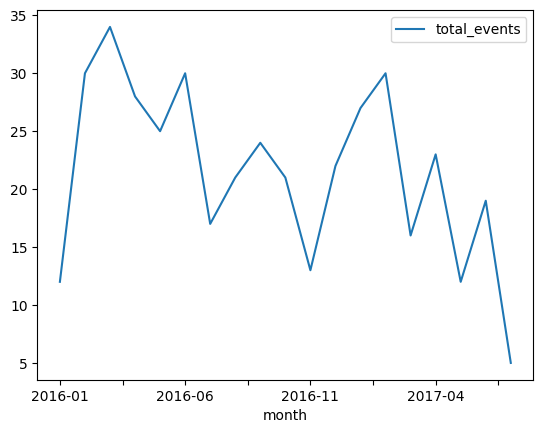

In [23]:
question = "Qual a evolução temporal dos eventos agregados mensalmente?"
analisador.apresentar(question)





query prompt: 

SQL query: SELECT strftime('%Y-%m-%d', DATE) AS date, COUNT(*) AS total_events FROM events GROUP BY date ORDER BY date;
           date  total_events
0    2016-01-01             1
1    2016-01-02             1
2    2016-01-06             1
3    2016-01-08             1
4    2016-01-10             1
..          ...           ...
281  2017-06-29             1
282  2017-07-04             2
283  2017-07-05             1
284  2017-07-06             1
285  2017-07-09             1

[286 rows x 2 columns]


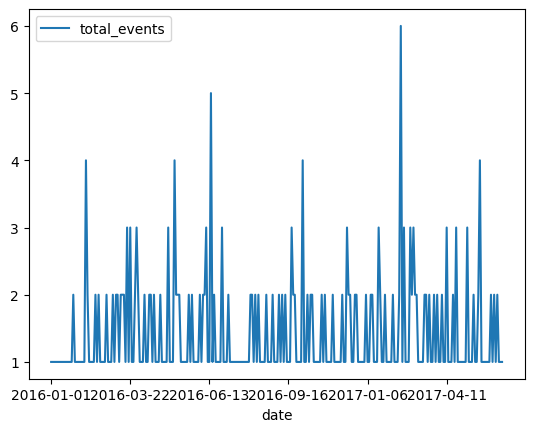

In [24]:
question = "Qual a evolução temporal dos eventos agregados diariamente?"
analisador.apresentar(question)

# Conferência

In [6]:
import pandas as pd
import sqlite3

# Teste de leitura
query = "SELECT * FROM events"
engine = sqlite3.Connection('database.db')

df = pd.read_sql(query, 
                 engine, 
                 dtype={ 'ID': 'int64', 
                        'COUNTRY': 'str', 
                        'PLACE': 'str', 
                        'SECTOR': 'str', 
                        'ACCIDENT_LEVEL': 'int64',
                        'DANGEROUSNESS': 'int64', 
                        'CRITICAL_RISK': 'str', 
                        'DESCRIPTION': 'str' },
                 parse_dates=['DATE'])

df['DATE'].value_counts()

DATE
2017-02-08    6
2016-06-16    5
2017-06-11    4
2016-05-04    4
2016-10-03    4
             ..
2016-07-18    1
2016-07-20    1
2016-07-21    1
2016-07-23    1
2017-07-09    1
Name: count, Length: 286, dtype: int64

In [7]:
df['MES_ANO'] = df['DATE'].dt.month.astype(str) + '_' + df['DATE'].dt.year.astype(str)
df['MES_ANO'].value_counts()

MES_ANO
3_2016     34
6_2016     30
2_2016     30
2_2017     30
4_2016     28
1_2017     27
5_2016     25
9_2016     24
4_2017     23
12_2016    22
10_2016    21
8_2016     21
6_2017     19
7_2016     17
3_2017     16
11_2016    13
1_2016     12
5_2017     12
7_2017      5
Name: count, dtype: int64